## Scalar coupling constant prediction using XGB with scikit-optimizer

In this kernel, we use features suggested in https://www.kaggle.com/artgor/brute-force-feature-engineering using the code from https://www.kaggle.com/kabure/simple-eda-lightgbm-autotuning-w-hyperopt/notebook


* [Additional methods](#addmethods)
* [Feature generation](#features)
* [Dataset preprocessing](#dataprep)
* [Feature selection, algorithm tuning, model training and prediction per molecule type](#preds)

22.07.2019

In [1]:
import os

import multiprocessing

import numpy as np 
import pandas as pd
pd.set_option("display.max_columns", 999)
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from time import time, ctime

import xgboost

# HPO
from skopt.space import Integer, Categorical, Real
from skopt.utils import use_named_args
from skopt import gp_minimize, gbrt_minimize
from skopt.plots import plot_convergence
from skopt.callbacks import DeltaXStopper, DeadlineStopper, DeltaYStopper
from skopt.callbacks import EarlyStopper

**Additional methods** <a class="anchor" id="addmethods"></a>

In [2]:
def get_params_SKopt(model, X, Y, space):
    cv_search = KFold(n_splits=3, shuffle=True, random_state = 0)
    
    HPO_PARAMS = {'n_calls':500,
                  'n_random_starts':10,
                  'acq_func':'EI',}

    @use_named_args(space)
    def objective(**params):
        model.set_params(**params)
        return -np.mean(cross_val_score(model, 
                                        X, Y, 
                                        cv=cv_search, 
                                        n_jobs = -1, 
                                        scoring='neg_mean_absolute_error'))
    
    reg_gp = gbrt_minimize(objective, 
                           space, 
                           verbose = False,
                           callback = [RepeatedMinStopper(n_best = 30), DeadlineStopper(total_time = 7200)],
                           **HPO_PARAMS,
                           random_state = 0)

    model.max_depth = reg_gp.x[0]
    model.min_child_weight = reg_gp.x[1]
    model.learning_rate = reg_gp.x[2]
    model.subsample = reg_gp.x[3]
    model.colsample_bytree = reg_gp.x[4]
    model.reg_alpha = reg_gp.x[5]
    model.reg_lambda = reg_gp.x[6]

    return [model,reg_gp]

def plotfig (ypred, yactual, strtitle, y_max, reg_gp):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    ax[0].scatter(ypred, yactual.values.ravel())
    ax[0].set_title(strtitle)
    ax[0].plot([(0, 0), (y_max, y_max)], [(0, 0), (y_max, y_max)])
    ax[0].set_xlim(0, y_max)
    ax[0].set_ylim(0, y_max)
    ax[0].set_xlabel('Predicted', fontsize=12)
    ax[0].set_ylabel('Actual', fontsize=12)

    plot_convergence(reg_gp, ax = ax[1]) 
    plt.show()

def feature_selection(threshold, train, test):
    corr_matrix = train.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print('\nThere are %d columns to remove.' % (len(to_drop)))
    train = train.drop(columns = to_drop)
    test = test.drop(columns = to_drop)  
    print (f'After dropping {train.shape[1]}' + ' features remain')   
    return [train, test, to_drop]

class RepeatedMinStopper(EarlyStopper):
    """Stop the optimization when there is no improvement in the minimum.
    Stop the optimization when there is no improvement in the minimum
    achieved function evaluation after `n_best` iterations.
    """
    def __init__(self, n_best=50):
        super(EarlyStopper, self).__init__()
        self.n_best = n_best
        self.count = 0
        self.minimum = np.finfo(np.float).max

    def _criterion(self, result):
        if result.fun < self.minimum:
            self.minimum = result.fun
            self.count = 0
        elif result.fun > self.minimum:
            self.count = 0
        else:
            self.count += 1

        return self.count >= self.n_best

def get_nan_col(df, N):
    # Get features with minimum N percentage of null observations 
    n_observ = int(np.round(N*np.size(df, 0)))
    allnull  = df.isnull().sum(axis=0).reset_index()
    lst_del  = [allnull.loc[i,'index'] for i in range(len(allnull)) if allnull.loc[i,0] > n_observ]  
    lst_proc = [allnull.loc[i,'index'] for i in range(len(allnull)) if allnull.loc[i,0] < n_observ and allnull.loc[i,0] > 0]
    return [lst_del, lst_proc]

def smart_fillna (common_df, Y, percent , fill_method_all, model_type, cv, scoring):   
    X = pd.DataFrame()
    X_test = pd.DataFrame()

    if model_type == 'linear':
        model = LinearRegression()
    elif model_type == 'rfr':
        model = RandomForestRegressor(n_estimators = 50, n_jobs = -1)
    
    lst_nan = get_nan_col(common_df, percent)
    print (f'To delete {len(lst_nan[0])}' + ' features')
    print (f'To process {len(lst_nan[1])}' + ' features')
    common_df.drop(lst_nan[0], axis = 1, inplace = True)
       
    if len(lst_nan[1]) > 0:
        print ('Processing features...')
        for feature in tqdm(lst_nan[1]):
            mas_score = []
            best_score = np.inf
            best_method = ''
            
            no_na = common_df.copy()
            no_na.dropna(axis='columns', inplace=True)
            
            for fill_method in fill_method_all:       
                common_df_copy = common_df.copy()

                if fill_method == 'mean':              
                    common_df_copy[feature].fillna(common_df_copy.mean()[feature], inplace = True)  
                elif fill_method == 'median': 
                    common_df_copy[feature].fillna(common_df_copy.median()[feature], inplace = True)  
                elif fill_method == 'interpolation':
                    common_df_copy[feature].fillna(common_df_copy.interpolate()[feature], inplace = True)  
                    
                X_train_feature = common_df_copy[common_df_copy['train'] == 1][feature]           
                X_train_feature = pd.DataFrame(np.nan_to_num(X_train_feature), columns = {feature})
                
                scaler = StandardScaler()
                if model_type == 'linear':
                    scaler.fit(X_train_feature.values.reshape(-1, 1))
                    X_train = scaler.transform(X_train_feature.values.reshape(-1, 1))  
                elif model_type == 'rfr':
                    X_train = X_train_feature.values.reshape(-1, 1)
                
                score = -np.mean(cross_val_score(model, 
                                            X_train, Y,      
                                            cv = cv, 
                                            scoring = scoring))
                mas_score.append(score)

                if score < best_score:
                    best_score = score 
                    best_method = fill_method
                del common_df_copy

            if best_method == 'mean':
                common_df[feature].fillna(common_df.mean()[feature], inplace = True)
            elif best_method == 'median': 
                common_df[feature].fillna(common_df.median()[feature], inplace = True)
            elif best_method == 'interpolation': 
                common_df[feature].fillna(common_df.interpolate()[feature], inplace = True)
            
            del no_na
            
            print(f'Best score:     {best_score}')
            
        X = common_df.loc[common_df['train'] == 1,:]
        X_test = common_df.loc[common_df['train'] == 0,:] 
        
    else:
        print('Zero features with missing values')
        
        X = common_df.loc[common_df['train'] == 1,:]
        X_test = common_df.loc[common_df['train'] == 0,:]
        
    X.drop('train', axis = 1, inplace = True)
    X_test.drop('train', axis = 1, inplace = True)
    return [X, X_test, Y.reset_index(drop=True), lst_nan[1]]         

**Feature generation** <a class="anchor" id="features"></a>

In [3]:
os.chdir('../../data/MolecularProperties/raw/')
os.listdir()

df_train = pd.read_csv('train.csv')
df_structure = pd.read_csv('structures.csv')
df_test = pd.read_csv('test.csv')

In [4]:
%%time
# Feature generation from https://www.kaggle.com/kabure/simple-eda-lightgbm-autotuning-w-hyperopt/notebook

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def create_features(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
    df[f'molecule_type_0_dist_std'] = df.groupby(['molecule_name', 'type_0'])['dist'].transform('std')
    df[f'molecule_type_0_dist_std_diff'] = df[f'molecule_type_0_dist_std'] - df['dist']
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
    df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
    df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
    df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
    df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    df[f'molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']

    df = reduce_mem_usage(df)
    return df

def map_atom_info(df, atom_idx):
    df = pd.merge(df, df_structure, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

df_train = map_atom_info(df_train, 0)
df_train = map_atom_info(df_train, 1)

df_test = map_atom_info(df_test, 0)
df_test = map_atom_info(df_test, 1)

## This is a very performative way to compute the distances
train_p_0 = df_train[['x_0', 'y_0', 'z_0']].values
train_p_1 = df_train[['x_1', 'y_1', 'z_1']].values
test_p_0 = df_test[['x_0', 'y_0', 'z_0']].values
test_p_1 = df_test[['x_1', 'y_1', 'z_1']].values

## linalg.norm, explanation:
## This function is able to return one of eight different matrix norms, 
## or one of an infinite number of vector norms (described below),
## depending on the value of the ord parameter.
df_train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
df_test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)

df_train['dist_x'] = (df_train['x_0'] - df_train['x_1']) ** 2
df_test['dist_x'] = (df_test['x_0'] - df_test['x_1']) ** 2
df_train['dist_y'] = (df_train['y_0'] - df_train['y_1']) ** 2
df_test['dist_y'] = (df_test['y_0'] - df_test['y_1']) ** 2
df_train['dist_z'] = (df_train['z_0'] - df_train['z_1']) ** 2
df_test['dist_z'] = (df_test['z_0'] - df_test['z_1']) ** 2

df_train['type_0'] = df_train['type'].apply(lambda x: x[0])
df_test['type_0'] = df_test['type'].apply(lambda x: x[0])

df_train = create_features(df_train)
df_test = create_features(df_test)
print(df_train.shape, df_test.shape)

submission = pd.DataFrame({'id': df_test['id'],
                          'scalar_coupling_constant' : [0] * len(df_test)})

df_train.drop(['id', 'molecule_name'], axis=1, inplace = True)
df_test.drop(['id', 'molecule_name'], axis=1, inplace = True)
print(df_train.shape, df_test.shape)


Mem. usage decreased to 826.28 Mb (68.2% reduction)
Mem. usage decreased to 430.10 Mb (68.8% reduction)
(4658147, 72) (2505542, 71)
(4658147, 70) (2505542, 69)
CPU times: user 1min 39s, sys: 1min 52s, total: 3min 31s
Wall time: 3min 30s


**Dataset preprocessing** <a class="anchor" id="dataprep"></a>

In [5]:
for f in ['atom_1', 'atom_0', 'type']:
        lbl = LabelEncoder()
        lbl.fit(list(df_train[f].values) + list(df_test[f].values))
        df_train[f] = lbl.transform(list(df_train[f].values))
        df_test[f] = lbl.transform(list(df_test[f].values))

df_train['type_0'] = df_train['type_0'].astype(int)
df_test['type_0'] = df_test['type_0'].astype(int)

In [10]:
# frac = .01 to take 10% of the dataset to speed up the calculus 
frac = .01

col = [c for c in df_train.columns if c not in ['scalar_coupling_constant']]
X = df_train.sample(frac = frac)[col]
Y = df_train.loc[X.index, 'scalar_coupling_constant']

X_TEST = df_test[col]

X['train'] = 1
X_TEST['train'] = 0

print(X.shape, X_TEST.shape, Y.shape)

(46581, 70) (2505542, 70) (46581,)


**Feature selection, algorithm tuning, model training and prediction per molecule type** <a class="anchor" id="preds"></a>

            Working with type 2JHC
Started at Mon Jul 22 11:24:56 2019

Fillna was started at Mon Jul 22 11:24:57 2019
To delete 10 features
To process 0 features
Zero features with missing values

Feature selection was started at Mon Jul 22 11:24:58 2019

There are 17 columns to remove.
After dropping 42 features remain
Common features after fillna and FS:
set()
Best score 1.631519357363383
Best iterations 57
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9661091274317843,
       criterion='mae', gamma=0, importance_type='gain',
       learning_rate=0.047693768526561535, max_delta_step=0, max_depth=46,
       metric='mae', min_child_weight=10, missing=None, n_estimators=3000,
       n_jobs=31, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0.5739824765559597,
       reg_lambda=0.19540521328304117, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.8598247545386767, verbosity=1)

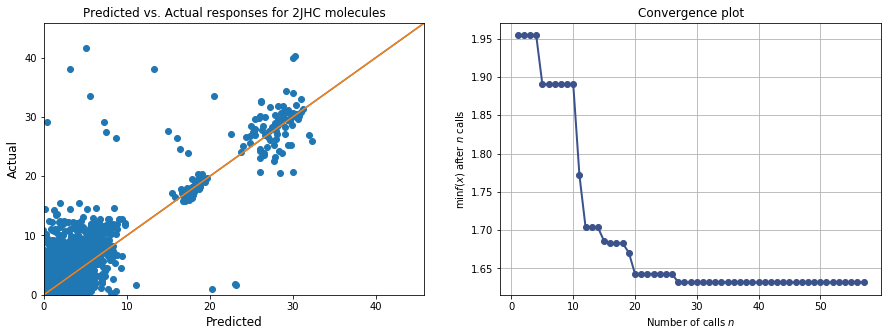

            Working with type 3JHC
Started at Mon Jul 22 11:27:12 2019

Fillna was started at Mon Jul 22 11:27:12 2019
To delete 8 features
To process 0 features
Zero features with missing values

Feature selection was started at Mon Jul 22 11:27:15 2019

There are 15 columns to remove.
After dropping 46 features remain
Common features after fillna and FS:
set()
Best score 1.6508595943450928
Best iterations 53
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9941548023027487,
       criterion='mae', gamma=0, importance_type='gain',
       learning_rate=0.03307660711708281, max_delta_step=0, max_depth=49,
       metric='mae', min_child_weight=7, missing=None, n_estimators=3000,
       n_jobs=31, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0.4414360052368478,
       reg_lambda=0.24032661896310764, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.590886682320935, verbosity=1)

F

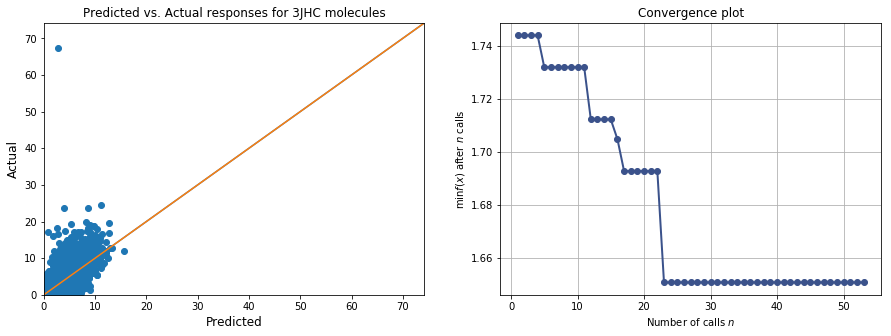

            Working with type 3JHH
Started at Mon Jul 22 11:29:39 2019

Fillna was started at Mon Jul 22 11:29:39 2019
To delete 10 features
To process 0 features
Zero features with missing values

Feature selection was started at Mon Jul 22 11:29:40 2019

There are 15 columns to remove.
After dropping 44 features remain
Common features after fillna and FS:
set()
Best score 1.2949269612630208
Best iterations 74
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.4176185429559224,
       criterion='mae', gamma=0, importance_type='gain',
       learning_rate=0.04974310640501511, max_delta_step=0, max_depth=31,
       metric='mae', min_child_weight=4, missing=None, n_estimators=3000,
       n_jobs=31, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0.12070529121819593,
       reg_lambda=0.23336677518488103, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.9325291807068699, verbosity=1)

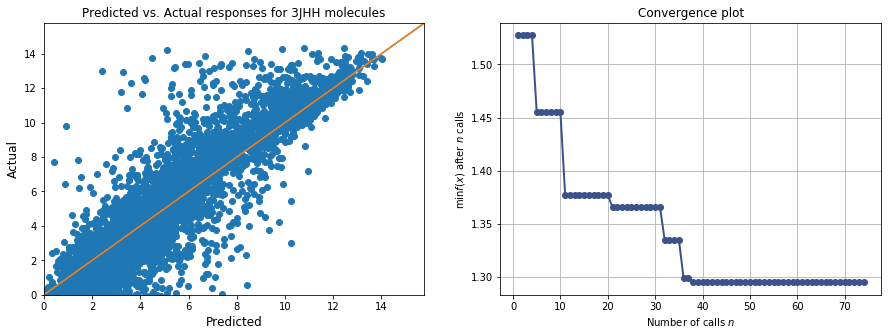

            Working with type 2JHH
Started at Mon Jul 22 11:30:36 2019

Fillna was started at Mon Jul 22 11:30:36 2019
To delete 9 features
To process 0 features
Zero features with missing values

Feature selection was started at Mon Jul 22 11:30:37 2019

There are 22 columns to remove.
After dropping 38 features remain
Common features after fillna and FS:
set()
Best score 0.9230800867080688
Best iterations 72
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8186578743025611,
       criterion='mae', gamma=0, importance_type='gain',
       learning_rate=0.08595968191279503, max_delta_step=0, max_depth=46,
       metric='mae', min_child_weight=4, missing=None, n_estimators=3000,
       n_jobs=31, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0.4220022500596011,
       reg_lambda=0.5484398117887261, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.8534359604586231, verbosity=1)

F

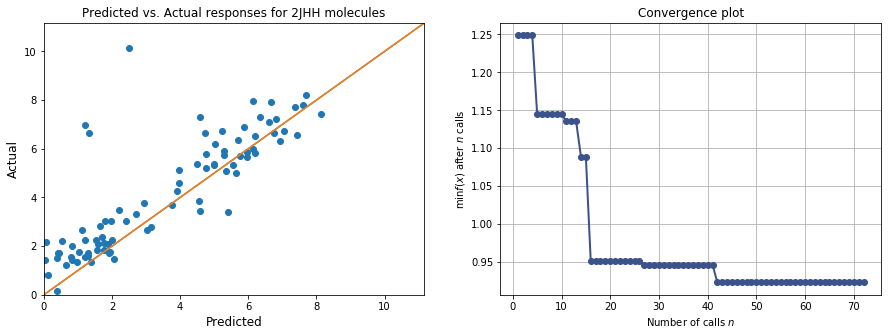

            Working with type 1JHC
Started at Mon Jul 22 11:31:10 2019

Fillna was started at Mon Jul 22 11:31:10 2019
To delete 10 features
To process 0 features
Zero features with missing values

Feature selection was started at Mon Jul 22 11:31:12 2019

There are 21 columns to remove.
After dropping 38 features remain
Common features after fillna and FS:
set()
Best score 3.9653499921162925
Best iterations 81
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8000956977256982,
       criterion='mae', gamma=0, importance_type='gain',
       learning_rate=0.05044678931623908, max_delta_step=0, max_depth=32,
       metric='mae', min_child_weight=3, missing=None, n_estimators=3000,
       n_jobs=31, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0.8895640350146338,
       reg_lambda=0.24121160540867287, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.8698609261307508, verbosity=1)


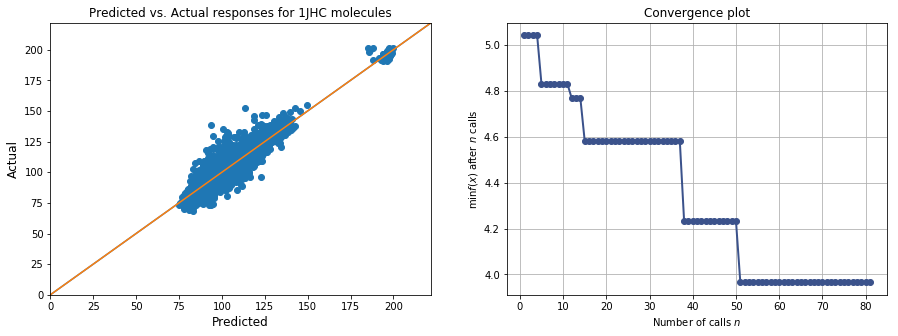

            Working with type 1JHN
Started at Mon Jul 22 11:32:30 2019

Fillna was started at Mon Jul 22 11:32:30 2019
To delete 9 features
To process 0 features
Zero features with missing values

Feature selection was started at Mon Jul 22 11:32:30 2019

There are 23 columns to remove.
After dropping 37 features remain
Common features after fillna and FS:
set()
Best score 2.8722029527028403
Best iterations 97
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9627435702567281,
       criterion='mae', gamma=0, importance_type='gain',
       learning_rate=0.09744802428985631, max_delta_step=0, max_depth=2,
       metric='mae', min_child_weight=2, missing=None, n_estimators=3000,
       n_jobs=31, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0.6810839668213977,
       reg_lambda=0.9493961981210445, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.7284352544992384, verbosity=1)

Fo

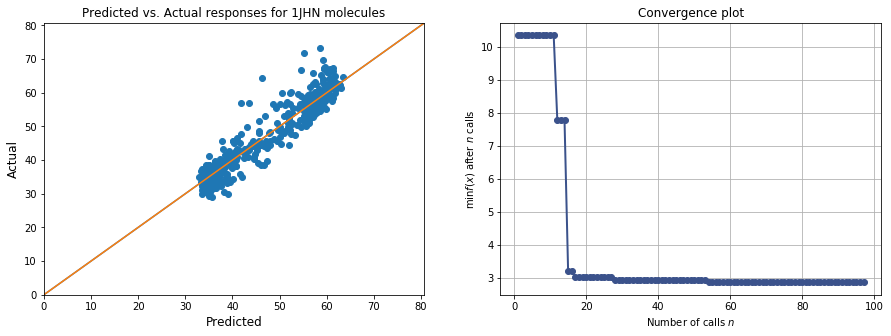

            Working with type 3JHN
Started at Mon Jul 22 11:32:50 2019

Fillna was started at Mon Jul 22 11:32:50 2019
To delete 9 features
To process 0 features
Zero features with missing values

Feature selection was started at Mon Jul 22 11:32:50 2019

There are 12 columns to remove.
After dropping 48 features remain
Common features after fillna and FS:
set()
Best score 0.7626256545384725
Best iterations 83
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9344414880809331,
       criterion='mae', gamma=0, importance_type='gain',
       learning_rate=0.01485623086108102, max_delta_step=0, max_depth=10,
       metric='mae', min_child_weight=6, missing=None, n_estimators=3000,
       n_jobs=31, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0.9770873750097386,
       reg_lambda=0.46213272553250495, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.9746176700757473, verbosity=1)



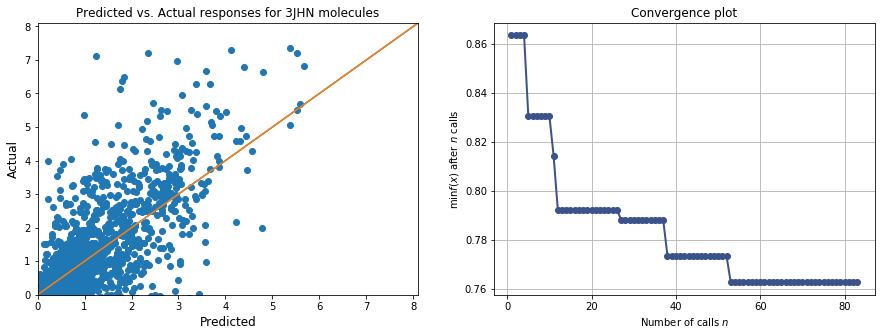

            Working with type 2JHN
Started at Mon Jul 22 11:33:23 2019

Fillna was started at Mon Jul 22 11:33:23 2019
To delete 9 features
To process 0 features
Zero features with missing values

Feature selection was started at Mon Jul 22 11:33:23 2019

There are 20 columns to remove.
After dropping 40 features remain
Common features after fillna and FS:
set()
Best score 1.6403253475824993
Best iterations 84
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9474725304117426,
       criterion='mae', gamma=0, importance_type='gain',
       learning_rate=0.058002289921911226, max_delta_step=0, max_depth=24,
       metric='mae', min_child_weight=6, missing=None, n_estimators=3000,
       n_jobs=31, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0.12893592720669383,
       reg_lambda=0.6445771387750869, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.9755188563466566, verbosity=1)


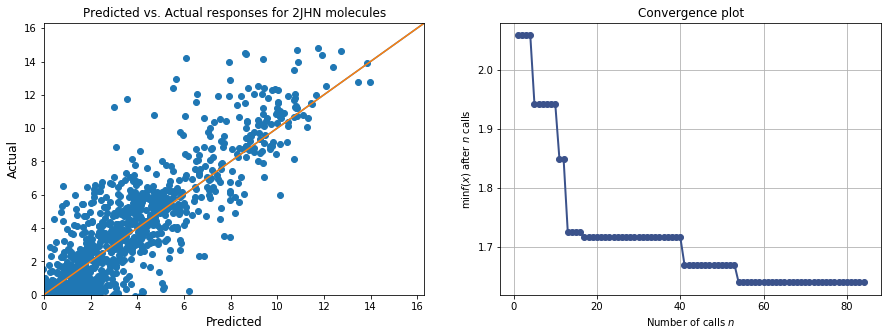

In [11]:
STATIC_PARAMS = {'metric': 'mae',
                'n_estimators': 100,
                'objective' : 'reg:squarederror',
                'criterion' : 'mae',
                }

space_SKopt = [Integer(2, 50, name='max_depth'),
         Integer(2, 100, name='min_child_weight'),
         Real(0.01, .1, name='learning_rate'),
         Real(0.1, 1, name='subsample'),
         Real(0.1, 1, name='colsample_bytree'),
         Real(0.1, 1, name='reg_alpha'),
         Real(0.1, 1, name='reg_lambda')]

Y_TEST_preds = pd.DataFrame({'ind': list(X_TEST.index), 
                             'type': X_TEST['type'].values, 
                             'prediction': [0] * len(X_TEST)})

n_fold = 3
cv = KFold(n_splits=n_fold, shuffle=True, random_state = 0)

for t in X['type'].unique():
    moltype = lbl.inverse_transform(X.loc[X['type'] == t]['type'])[0]
    print('='*45)
    print(' '*12 + f'Working with type {moltype}')
    print('='*45)
    
    print('Started at', ctime())
        
    mae, r2 = [], []
    X_t = X.loc[X['type'] == t]
    X_TEST_t = X_TEST.loc[X_TEST['type'] == t]
    y_t = Y.loc[X['type'] == t]
    
    print('\nFillna was started at', ctime())
    fill_method_all = ['mean', 'median', 'interpolation']
    cv_fillna = KFold(n_splits=3, shuffle=True, random_state = 0)
    
    # The next method deals with missing values in dataset considering three possible strategies from fill_method_all.
    # The best strategy is chosen after MAE score evaluation for the linear model (random forest alg can be set using 'rfr' keyword instead of 'linear').
    # Parameter N defines the percentage of observations with missing values to decide that the feature should be dropped or processed (fillna).  
    # If you'd like to drop all features with any missing values, N must be set to null.
    N = 0.0
    [X_t, X_TEST_t, y_t, lst_proc] = smart_fillna(pd.concat([X_t, X_TEST_t], ignore_index = True), y_t, N, 
                                                                                                    fill_method_all, 
                                                                                                    'linear', 
                                                                                                    cv_fillna,
                                                                                                    'neg_mean_absolute_error',)
    print('\nFeature selection was started at', ctime())
    [X_t, X_TEST_t, lst_drop] = feature_selection(0.9, X_t, X_TEST_t)
    print('Common features after fillna and FS:')
    print(set(lst_proc)&set(lst_drop))
    
    oof = np.zeros(len(X_t))
    X_p = X_t.sample(frac = 0.25)
    Y_p = y_t.loc[X_p.index]
    
    model = xgboost.XGBRegressor(**STATIC_PARAMS)
    [best_model,reg_gp] = get_params_SKopt(model, X_p, Y_p, space_SKopt)
      
    print ('Best score', reg_gp.fun)
    print ('Best iterations', len(reg_gp.x_iters))
    
    best_model.n_jobs = multiprocessing.cpu_count()-1
    best_model.n_estimators = 3000
    print(best_model)
    
    for fold_n, (train_index, valid_index) in enumerate(cv.split(X_t)):
        print('\nFold', fold_n, 'started at', ctime())

        X_train = X_t.iloc[train_index,:]
        X_valid = X_t.iloc[valid_index,:]

        Y_train = y_t.iloc[train_index]
        Y_valid = y_t.iloc[valid_index]      
        
        best_model.fit(X_train, Y_train, 
               eval_metric = 'mae',    
               eval_set = [(X_valid, Y_valid)],
               verbose = False,
               early_stopping_rounds = 10)

        y_pred = best_model.predict(X_valid, 
                                   ntree_limit = best_model.best_iteration)

        mae.append(mean_absolute_error(Y_valid, y_pred))
        r2.append(r2_score(Y_valid, y_pred))
        
        print('Best score', best_model.best_score) 
        print('Best iteration', best_model.best_iteration)  
            
        Y_TEST_preds.loc[Y_TEST_preds['type'] == t, 'prediction'] += best_model.predict(X_TEST_t, 
                                                        ntree_limit = best_model.best_iteration)
        oof[valid_index] = y_pred
        
    Y_TEST_preds.loc[Y_TEST_preds['type'] == t, 'prediction'] /= n_fold

    print('='*45)
    print('CV mean MAE: {0:.4f}, std: {1:.4f}.'.format(np.mean(mae), np.std(mae)))
    print('CV mean R2:  {0:.4f}, std: {1:.4f}.'.format(np.mean(r2), np.std(r2)))
    
    plotfig(oof, y_t, 'Predicted vs. Actual responses for ' + moltype + ' molecules',max(y_t) + 0.1*max(y_t), reg_gp)   


In [13]:
submission['scalar_coupling_constant'] = Y_TEST_preds['prediction'] 
print(submission.head())
submission.to_csv("submission_PMP.csv", index=False)

        id  scalar_coupling_constant
0  4658147                  8.140710
1  4658148                183.183853
2  4658149                  3.868919
3  4658150                178.950536
4  4658151                  8.741212
